# 1. Named Entity Recognition

In this notebook, we explore Named Entity Recognition (NER) which is **automatically finding and classifying key pieces of information in text**, such as people, organizations, locations, or other specific entities.

NER is especially useful in search systems. When a database contains thousands of documents, simply relying on keyword search can return too many results. **By combining semantic similarity with entity extraction, we can narrow down the search space and surface more relevant results**.

You’ve already seen this idea in everyday life:
- Job boards that let you filter results by company or skill names
- News sites that let you browse by politician, city or sports team
- Research databases that let you filter by author or journal



In this notebook, we’ll build a simplified version of that workflow. We will:
- **embed the query** → get semantic similarity scores with documents
- **extract named entities** → identify the most important keywords/topics
- **apply entity filters in Pinecone** → return results that are both semantically relevant and constrained to the specified entities







# Setup: Installing Required Libraries

Before we begin, we need to install the necessary Python libraries. Run the cell below to install all dependencies for this notebook.

In [1]:
# Install required libraries
!pip install -q sentence-transformers transformers pinecone datasets torch

print("✅ All libraries installed successfully!")
print("⚠️  IMPORTANT: Please restart your kernel/runtime now before running the next cell!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.6/587.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.3/259.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.0 MB/s eta 0:00:00
✅ All libraries installed successfully!
⚠️  IMPORTANT: Please restart your kernel/runtime now before running the next cell!


In [2]:
# Importing libraries

from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

import torch

import pandas as pd
import os
from pinecone import Pinecone, ServerlessSpec

# For data preprocessing
import ast

from tqdm.auto import tqdm

We’ll use a pre-trained BERT-based model called `dslim/bert-base-NER`. This model has been fine-tuned specifically for Named Entity Recognition tasks. It works at the token level - it looks at each word (or subword) in the input text and assigns it an entity label:
- `ORG`: organization
- `PER`: person's name
- `LOC`: location
- `MISC`: miscellaneous entity

You can read more about this model on [Hugging Face's website](https://huggingface.co/dslim/bert-base-NER).

In [3]:
model = "dslim/bert-base-NER"

Let's load the tokenizer which splits input text into tokens in exactly the same way the model was trained and prepares it for inference:

In [4]:
# Loading the tokenizer
ner_tokenizer = AutoTokenizer.from_pretrained(model)

tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Now, we'll load the NER model:

In [5]:
# Loading the NER model
ner_model = AutoModelForTokenClassification.from_pretrained(model)
ner_model

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

To run NER, we use a pipeline that wraps the model and tokenizer together and gives us a simple function we can call on text:

In [6]:
# Pipeline
ner_pipeline = pipeline('ner',
                        # Model
                        model = ner_model,
                        # Tokenizer
                        tokenizer = ner_tokenizer,
                        # BERT splits words into subword pieces: option "max" groups those pieces back into whole words
                        # and keeps the label with the highest confidence for each word span
                        aggregation_strategy = "max",
                        # CPU
                        device= None)

Device set to use cpu


Our NER model identified and categorized several key named entities in the sentence. It recognized organizations like DeepMind, Meta, and Meta Superintelligence Labs as `ORG`, individuals like Demis Hassabis, Lex Fridman, and Mark Zuckerberg as `PER`, and AI as a miscellaneous entity (`MISC`). Each detection includes a high confidence score, along with the exact text span in which the entity appeared.

In [7]:
ner_pipeline("""DeepMind CEO Demis Hassabis recently suggested on the Lex Fridman podcast that
Meta's aggressive hiring spree reflects its attempt to catch up in the AI race—
this includes launching Meta Superintelligence Labs under CEO Mark Zuckerberg.""")

[{'entity_group': 'ORG',
  'score': np.float32(0.9984956),
  'word': 'DeepMind',
  'start': 0,
  'end': 8},
 {'entity_group': 'PER',
  'score': np.float32(0.99966085),
  'word': 'Demis Hassabis',
  'start': 13,
  'end': 27},
 {'entity_group': 'PER',
  'score': np.float32(0.9971025),
  'word': 'Lex Fridman',
  'start': 54,
  'end': 65},
 {'entity_group': 'ORG',
  'score': np.float32(0.99914956),
  'word': 'Meta',
  'start': 79,
  'end': 83},
 {'entity_group': 'MISC',
  'score': np.float32(0.9862601),
  'word': 'AI',
  'start': 150,
  'end': 152},
 {'entity_group': 'ORG',
  'score': np.float32(0.99918956),
  'word': 'Meta Superintelligence Labs',
  'start': 183,
  'end': 210},
 {'entity_group': 'PER',
  'score': np.float32(0.99974495),
  'word': 'Mark Zuckerberg',
  'start': 221,
  'end': 236}]

### 📝 EXERCISE 1: Extract Entities from Your Own Text (5-7 minutes)


**Your task:**
1. Create a sentence or short paragraph with at least 3 named entities (people, organizations, or locations)
   - Example: "Microsoft CEO Satya Nadella announced new AI features in Seattle."
2. Run the NER pipeline on your text
3. Print the detected entities with their types (PER, ORG, LOC)
4. Analyze: Did the model correctly identify all entities? Were there any mistakes?



In [8]:
# YOUR CODE HERE


# 2. Enhancing Semantic Search with NER

Now that we've seen how NER can automatically highlight people, places or organizations in text, let’s put it to work in a real search scenario.

Imagine a tech article search platform. Users can type questions like "How to learn NLP?" or "Best Python libraries for deep learning". The system first finds articles semantically related to the question (so synonyms work), but it also uses Named Entity Recognition to find important terms (like "NLP", "Python", "PyTorch") and **filters results to only include articles that mention those entities**. This means if someone searches "NLP with PyTorch", they won’t get generic NLP articles but **they’ll get ones specifically mentioning PyTorch**.

That’s exactly what we’ll build in the upcoming demo. Here are the steps we'll follow:

1. Load and **preprocess the dataset** - we’ll reuse the Medium dataset containing tech articles
2. **Extract named entities** from each article using a NER model
3. **Build metadata** that includes those entities along with other useful fields like title, authors and year
4. **Generate embeddings** for each article

Finally, we’ll upsert everything into Pinecone. When we'll be querying the database, Pinecone will combine both to return results:
- **Vector similarity** (to capture semantic meaning)
- and **Entity metadata filters** (to narrow results to those mentioning specific terms)





## 2.1 Loading and Preprocessing the Dataset

The first step is loading the dataset and preprocessing of some of the columns - cleaning text, parsing lists (for columns "authors" and "tags"), creating new columns "timestamp_iso" and "year", removing missing value and creating unique identifiers for each article.

In [34]:
# Loading
data = pd.read_csv("articles.csv")

In [35]:
# Dataset Sampling for Faster Processing
# -------------------------------------
# The full dataset is very large and entity extraction can take significant time.
# We'll create a representative sample that maintains the diversity of the data
# while reducing processing time for demonstration purposes.

print(f"Original dataset size: {len(data):,} articles")
print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB\n")

# Create a stratified sample if 'category' column exists, otherwise random sample
SAMPLE_SIZE = 250  # Adjust this number based on your needs

if len(data) > SAMPLE_SIZE:
    # Try stratified sampling by category if available
    if 'category' in data.columns:
        # Sample proportionally from each category to maintain distribution
        data = data.groupby('category', group_keys=False).apply(
            lambda x: x.sample(min(len(x), max(1, int(SAMPLE_SIZE * len(x) / len(data)))),
                              random_state=42)
        ).reset_index(drop=True)
        print(f"✓ Created stratified sample maintaining category distribution")
    else:
        # Random sampling
        data = data.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
        print(f"✓ Created random sample")

    print(f"\nSampled dataset size: {len(data):,} articles")
    print(f"Memory usage: {data.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"\n💡 Tip: Adjust SAMPLE_SIZE variable above to change sample size")
else:
    print(f"Dataset is already small ({len(data)} articles), no sampling needed.")

Original dataset size: 2,500 articles
Memory usage: 28.61 MB

✓ Created random sample

Sampled dataset size: 250 articles
Memory usage: 2.79 MB

💡 Tip: Adjust SAMPLE_SIZE variable above to change sample size


In [36]:
def _safe_literal_eval(x):
    # Parsing a Python-literal string to a Python object
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return x
    return x

def preprocess_articles(df: pd.DataFrame) -> pd.DataFrame:
    dataset = data.copy()

    # "text" column: ensuring "text" is a stripped string
    if "text" in dataset.columns:
        dataset["text"] = dataset["text"].astype(str).str.strip()

    # Parsing columns "tags" and "authors" into Python lists
    if "tags" in dataset.columns:
        dataset["tags"] = dataset["tags"].apply(_safe_literal_eval)
    if "authors" in dataset.columns:
        def _to_list(x):
            if isinstance(x, list):
                return x
            if pd.notna(x):
                parsed = _safe_literal_eval(x)
                return parsed if isinstance(parsed, list) else [str(parsed)]
            return []
        dataset["authors"] = dataset["authors"].apply(_to_list)

    # Converting "timestamp" to pandas datetime objects. Creating new columns "timestamp_iso" and "year"
    if "timestamp" in dataset.columns:
        ts = pd.to_datetime(dataset["timestamp"], utc=True, format="mixed", errors="coerce")
        dataset["timestamp_iso"] = ts.dt.strftime("%Y-%m-%dT%H:%M:%SZ")
        dataset["year"] = ts.dt.year.astype("Int64")

    return dataset

In [37]:
# Calling preprocess_articles function
clean_data = preprocess_articles(data)

In [38]:
# Inspect the data
clean_data.head(2)

,Unnamed: 0,title,text,url,authors,timestamp,tags,timestamp_iso,year
0,5804,Anti-maskers Pushing for Herd Immunity Just Wa...,They just want minorities gone\n\nAmong the mi...,https://medium.com/discourse/anti-maskers-who-...,[Henner Townlove],2020-10-16 08:21:23.109000+00:00,"[Minorities, BlackLivesMatter, Racism, Herd Im...",2020-10-16T08:21:23Z,2020
1,4526,Six Wrong Predictions Reported By the New York...,The New York Times is one of the prominent Ame...,https://medium.com/swlh/six-wrong-predictions-...,[Massùod Hemmat],2020-12-15 19:03:49.558000+00:00,"[The New York Times, Predictions, Journalism, ...",2020-12-15T19:03:49Z,2020


We'll also drop missing values and create a new column with unique IDs:

In [39]:
# Dropping missing values
clean_data.dropna(inplace=True)

In [40]:
# Creating unique identifiers
clean_data["id"] = clean_data.index.astype(str)

In [41]:
# Inspecting
clean_data.head(2)

,Unnamed: 0,title,text,url,authors,timestamp,tags,timestamp_iso,year,id
0,5804,Anti-maskers Pushing for Herd Immunity Just Wa...,They just want minorities gone\n\nAmong the mi...,https://medium.com/discourse/anti-maskers-who-...,[Henner Townlove],2020-10-16 08:21:23.109000+00:00,"[Minorities, BlackLivesMatter, Racism, Herd Im...",2020-10-16T08:21:23Z,2020,0
1,4526,Six Wrong Predictions Reported By the New York...,The New York Times is one of the prominent Ame...,https://medium.com/swlh/six-wrong-predictions-...,[Massùod Hemmat],2020-12-15 19:03:49.558000+00:00,"[The New York Times, Predictions, Journalism, ...",2020-12-15T19:03:49Z,2020,1


## 2.2 Extracting Named Entities


The next step is extracting named entities. We need to make sure that each created entity list will be clean and free of duplicates. For example, if our NER model extracts ["Python", "Python", "NLP"], we don’t want duplicates cluttering our metadata. Thus, we will create a function called `dedupe_entities()` that removes duplicates:

In [42]:
# Deduplicate extracted entities per document
def dedupe_entities(entity_lists):
    return [sorted(set(map(str, ents))) for ents in entity_lists]



Next, we'll create another helper function `extract_entities()`, which applies our previously initialized `ner_pipeline` (with the NER model from the first section of this notebook). This function takes a list of texts, runs the model on each one and returns the named entities it detects. We’ll later use it to extract entities for all articles in our dataset.

In [43]:
# Extracting named entities
def extract_entities(texts):
    results = []
    for t in texts:
        ents = ner_pipeline(t)        # NER model
        labels = [ent["word"] for ent in ents]
        results.append(labels)
    return results

Running the NER model on thousands of articles can be slow and memory-intensive, so instead of processing everything at once, we split the dataset into **smaller batches**:

In [44]:
# Extracting entities in batches

# Take 64 texts at a time
BATCH_SIZE = 64
texts = clean_data["text"].astype(str).tolist()
all_entities = []

for i in tqdm(range(0, len(texts), BATCH_SIZE), desc = "Extracting entities"):
    batch = texts[i:i+BATCH_SIZE]
    # For each batch, run the function with the NER model
    batch_results = extract_entities(batch)
    # Accumulate results into one list
    all_entities.extend(batch_results)

# Deduplicate and add named entities as a new column
clean_data["named_entity"] = dedupe_entities(all_entities)

Extracting entities:   0%|          | 0/4 [00:00<?, ?it/s]

In [45]:
# Inspect the data
clean_data.head()

,Unnamed: 0,title,text,url,authors,timestamp,tags,timestamp_iso,year,id,named_entity
0,5804,Anti-maskers Pushing for Herd Immunity Just Wa...,They just want minorities gone\n\nAmong the mi...,https://medium.com/discourse/anti-maskers-who-...,[Henner Townlove],2020-10-16 08:21:23.109000+00:00,"[Minorities, BlackLivesMatter, Racism, Herd Im...",2020-10-16T08:21:23Z,2020,0,"[California, China, Chinese, Donald, Trump]"
1,4526,Six Wrong Predictions Reported By the New York...,The New York Times is one of the prominent Ame...,https://medium.com/swlh/six-wrong-predictions-...,[Massùod Hemmat],2020-12-15 19:03:49.558000+00:00,"[The New York Times, Predictions, Journalism, ...",2020-12-15T19:03:49Z,2020,1,"[Airplanes & Flying, American, Apple & iPhone,..."
2,4351,The #1 Mistake I Made on Medium this Month,The #1 Mistake I Made on Medium this Month\n\n...,https://medium.com/the-innovation/the-1-mistak...,[Michelle Loucadoux],2020-12-27 21:57:42.493000+00:00,"[Writing, Writing Tips, Advice, Inspiration, B...",2020-12-27T21:57:42Z,2020,2,"[Bermix Studio, Forbes, Gary Vaynerchuk, Jon S..."
3,9125,4 Signs You May Have an Anxious Attachment Style,4 Signs You May Have an Anxious Attachment Sty...,https://medium.com/wholistique/4-signs-you-may...,[Casey A.],2020-09-28 15:41:39.895000+00:00,"[Relationships, Attachment, Self Development, ...",2020-09-28T15:41:39Z,2020,3,"[Diane Poole Heller, Power of Attachment, The ..."
4,6172,Revit Like It’s Sketchup,Paper Architecture Illustration\n\nThis is not...,https://medium.com/paper-architecture/revit-li...,[Dan Edleson],2019-05-23 06:28:38.087000+00:00,"[Sketchup, Architecture, Bim, Design, Revit]",2019-05-23T06:28:38Z,2019,4,"[Autodesk, Dynamo, Grasshopper, InDesign, Mass..."


## 2.3 Building Metadata

After extracting entities, we enrich our dataset with a new metadata column. This metadata combines several fields - title, authors, timestamp, year, tags - together with the extracted named entities. This ensures that when we query Pinecone later, we can filter not only by semantic similarity but also by these metadata attributes.

In [46]:
# Creating "metadata" column
clean_data['metadata'] = clean_data.apply(lambda x: {
    "title": x["title"],
    "authors": x["authors"],
    "timestamp": x["timestamp_iso"],
    "year": x["year"],
    "tags": x["tags"],
    "entities": x["named_entity"]
}, axis=1)

In [47]:
# Next, we prepare a new dataframe df_to_upsert with IDs and metadata
df_to_upsert = clean_data[["id", "metadata"]].copy()
df_to_upsert.head()

,id,metadata
0,0,{'title': 'Anti-maskers Pushing for Herd Immun...
1,1,{'title': 'Six Wrong Predictions Reported By t...
2,2,{'title': 'The #1 Mistake I Made on Medium thi...
3,3,{'title': '4 Signs You May Have an Anxious Att...
4,4,"{'title': 'Revit Like It’s Sketchup', 'authors..."


## 2.4 Generating Embeddings

Finally, we'll create embeddings for each article using the pre-trained `all-MiniLM-L6-v2` model from SentenceTransformers and store them in the dataframe as Python lists under a new column "values":

In [48]:
# Loading embedding model
retriever = SentenceTransformer("all-MiniLM-L6-v2", device="cpu")

# Getting texts
texts = clean_data["text"].tolist()

# Creating embeddings
embeddings = retriever.encode(
    texts,
    batch_size=64,
    show_progress_bar=True,
    convert_to_numpy=True,
    normalize_embeddings=False
)

# Storing embeddings in DataFrame as lists
df_to_upsert["values"] = [vec.tolist() for vec in embeddings]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [49]:
df_to_upsert.head()

,id,metadata,values
0,0,{'title': 'Anti-maskers Pushing for Herd Immun...,"[0.032676707953214645, 0.04764920100569725, 0...."
1,1,{'title': 'Six Wrong Predictions Reported By t...,"[0.0008722133934497833, -0.03343416005373001, ..."
2,2,{'title': 'The #1 Mistake I Made on Medium thi...,"[0.008692548610270023, -0.06024245172739029, 0..."
3,3,{'title': '4 Signs You May Have an Anxious Att...,"[0.08500546962022781, -0.029169099405407906, 0..."
4,4,"{'title': 'Revit Like It’s Sketchup', 'authors...","[-0.10077796876430511, 0.025403376668691635, 0..."


## 2.5 Creating a Pinecone Index and Upserting the Data

Now that we’ve prepared our dataframe with unique IDs, metadata (including named entities) and vector embeddings, we’re ready to upsert everything into Pinecone.

In [52]:
from google.colab import userdata

# Load API key from Google Colab secrets
pinecone_client = Pinecone(api_key=userdata.get('PINECONE_API_KEY'))

In [53]:
# Creating an Index
pinecone_client.create_index(name = "articles-ner",
                             dimension = 384,
                             metric = "cosine",
                             spec = ServerlessSpec(
                                 cloud = "aws",
                                 region = "us-east-1"
                             ))

{
    "name": "articles-ner",
    "metric": "cosine",
    "host": "articles-ner-lxoswle.svc.aped-4627-b74a.pinecone.io",
    "spec": {
        "serverless": {
            "cloud": "aws",
            "region": "us-east-1"
        }
    },
    "status": {
        "ready": true,
        "state": "Ready"
    },
    "vector_type": "dense",
    "dimension": 384,
    "deletion_protection": "disabled",
    "tags": null
}

In [54]:
# Connecting
index = pinecone_client.Index("articles-ner")

In [55]:
# Upserting the data
index.upsert_from_dataframe(
    df_to_upsert,
    batch_size = 500,
    show_progress = True)

sending upsert requests:   0%|          | 0/250 [00:00<?, ?it/s]

{'upserted_count': 250}

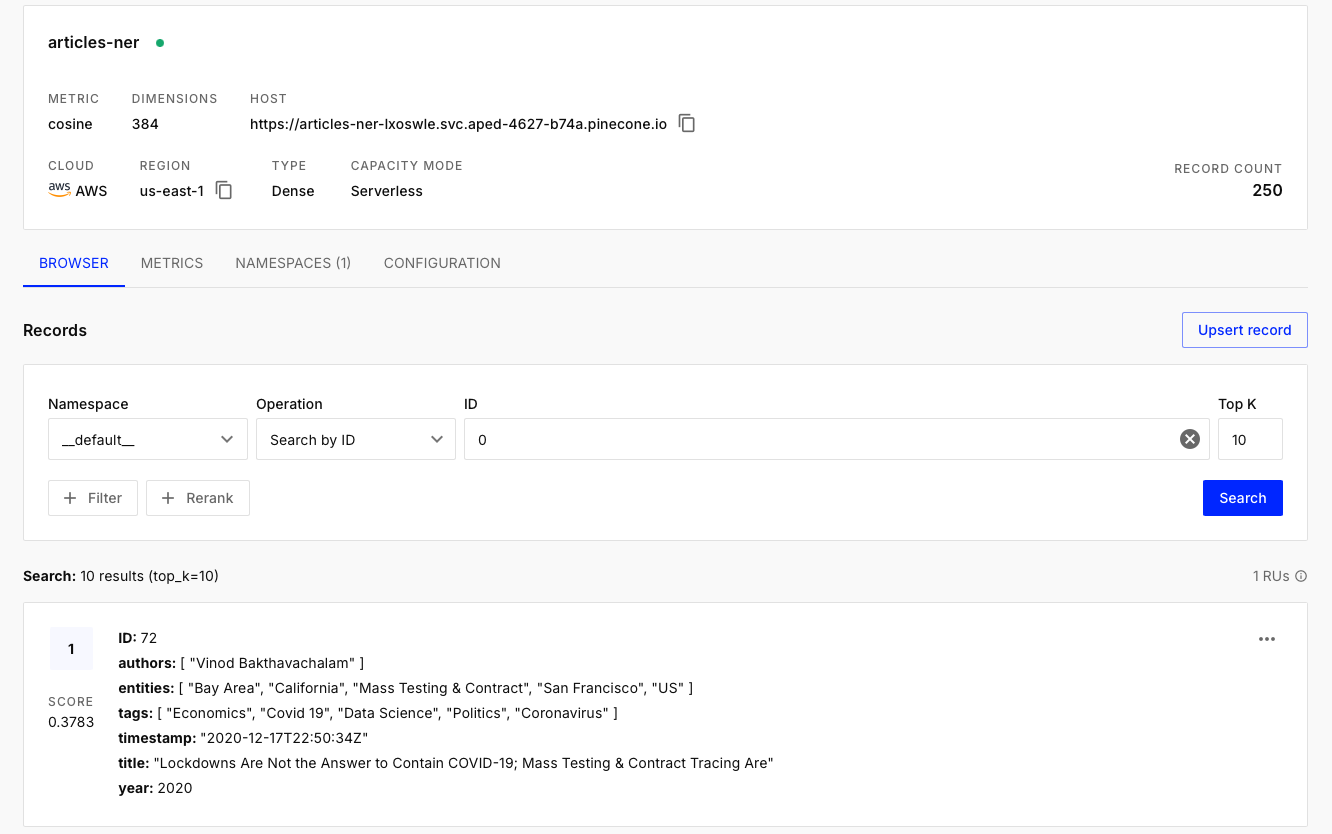

## 2.6 Querying the Database

First, we take our query and convert it to embedding:

In [77]:
# Our question
query = "Find me articles regarding Artificial Intelligence"

# Embedding question to query vector
emb_query = retriever.encode(query).tolist()

Next, we run our NER pipeline on the query to detect important terms. In this case, the model extracts the entity "UX", which we then use as a metadata filter:

In [78]:
# Extracting named entity
entity_filter = extract_entities([query])[0]
entity_filter

['Artificial', 'Intelligence']

Finally, we query Pinecone with both the embedding and the entity filter:

In [86]:
responses = index.query(
    vector = emb_query,
    top_k= 5,
    include_metadata = True,
    # Using named entity for filtering
    filter = {"entities": {"$in" : entity_filter}})

In [87]:
for response in responses["matches"]:
    print(f"{response['score']:.4f}", " ", response["metadata"].get("entities", []))

0.4005   ['AI', 'Artificial', 'Artificial Intelligence', 'COVID - 19', 'Consortium', 'Data and Artificial Intelligence', 'Ethics', 'Fight Against COVID - 19', 'GAIEC', 'Global AI Ethics Consortium', 'Intelligence', 'Pandemics', 'Stefaan Verhulst', 'TUM Institute for Ethics in Artificial Intelligence', 'of Data']
0.3776   ['AI', 'Artificial', 'Austria', 'Maria', 'Maria Theresa', 'Schonbrunn Palace', 'Wolfgang', 'Wolfgang von Kempelen']


In [88]:
# Displaying the results in a clean format
for respose in responses["matches"]:
    print(f"ID: {respose['id']}")
    print(f"Score: {respose['score']:.4f}")  # 4 decimal places
    metadata = respose.get("metadata", {})
    print("Metadata:")
    for key, value in metadata.items():
            print(f" {key}: {value}")
    print("\n" + "-" * 40 + "\n")

ID: 89
Score: 0.4005
Metadata:
 authors: ['The Govlab']
 entities: ['AI', 'Artificial', 'Artificial Intelligence', 'COVID - 19', 'Consortium', 'Data and Artificial Intelligence', 'Ethics', 'Fight Against COVID - 19', 'GAIEC', 'Global AI Ethics Consortium', 'Intelligence', 'Pandemics', 'Stefaan Verhulst', 'TUM Institute for Ethics in Artificial Intelligence', 'of Data']
 tags: ['AI', 'Data', 'Covid 19']
 timestamp: 2020-04-15T14:12:49Z
 title: The Global AI Ethics Consortium (GAIEC) on Ethics and the Use of Data and Artificial Intelligence in the Fight Against COVID-19 and other Pandemics is officially launched
 year: 2020.0

----------------------------------------

ID: 6
Score: 0.3776
Metadata:
 authors: ['Benjamin Rhodes']
 entities: ['AI', 'Artificial', 'Austria', 'Maria', 'Maria Theresa', 'Schonbrunn Palace', 'Wolfgang', 'Wolfgang von Kempelen']
 tags: ['Computer History', 'Artificial Intelligence', 'Technology', 'History', 'Machine Learning']
 timestamp: 2020-06-06T13:31:01Z
 titl

The output shows 2 matches, each with a similarity score and the entities associated with the article.

### 📝 EXERCISE 2: Search with Entity Filtering



**Your task:**
1. Create a query that mentions a specific entity (person, organization, or location)
   - Examples: "How does Python work with AWS?", "Where can I find Machine Learning tutorials?", How do I learn React development?.
2. Extract entities from your query using the NER pipeline
3. Create an embedding for your query text
4. Query the Pinecone index with:
   - The query embedding (for semantic similarity)
   - An entity filter (to only return documents mentioning that entity)
5. Display the top 3 results with their scores and detected entities


In [101]:
# YOUR CODE HERE
